# **Relatório Técnico: Estudo Exploratório sobre Detecção Automática de Discurso de Ódio**

|Relatório Técnico ID  |2021/08|
|--|--|
| Título |Estudo Exploratório sobre Detecção Automática de Discurso de Ódio|
| Autoras | Hannah Plath, Paula Dornhofer|
| Data de Criação| 2020 - 08|



#**Descrição do Notebook**

Este notebook contém um estudo exploratório sobre detecção automática de discurso de ódio. Para tal é utilizada a base [OffComBR](https://github.com/eduardofroes/OffComBR).



# Introdução e Importação da Base


**Importações**

**NLTK** - Natural Language Toolkit é uma biblioteca para Processamento de Linguagem Natural que utiliza o Python

**Scikit-Learn** - is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

**Pandas** - biblioteca que se utiliza da linguagem Python para manipular e analisar dados: manipulação de *dataframes*

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from string import punctuation
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import numpy as np
import re

%load_ext google.colab.data_table

**Trazer a base de dados**

Comando **!git clone** copia os documentos do github e cria uma pasta dentro do colab com os arquivos

In [ ]:
!git clone https://github.com/eduardofroes/OffComBR.git

Cloning into 'OffComBR'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 25 (delta 0), reused 2 (delta 0), pack-reused 22
Unpacking objects: 100% (25/25), done.


In [ ]:
data_frame = pd.read_csv('./OffComBR/OffComBR.csv', delimiter=';', encoding='utf-8', header = None, names = ['Label', 'Data'], error_bad_lines = True, warn_bad_lines = True)
dff = pd.DataFrame(data_frame)
dff

,Label,Data
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,no,Podiam retirar dos lucros dos bancos
4,no,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...
...,...,...
1028,no,Cruz so tem agilidade mesmo poder de nocaute z...
1029,no,Meus caros amigos enigmaticosNao deveriam comp...
1030,yes,Ele chamava pra atras da escola e sentava nos ...
1031,no,Jhalim Rabei ate fiquei assustado comecei a le...


Quantas amostras têm *label* **sim** e quantas tem *label* **não** ?

In [ ]:
yes = len(data_frame[data_frame.Label == 'yes'])
no = len(data_frame[data_frame.Label == 'no'])

print("Amostras Classificadas como yes:", yes)
print("Amostras Classificadas como no:", no)

Amostras Classificadas como yes: 202
Amostras Classificadas como no: 831


# Pré-processamento dos Dados e Análise dos Data Frames

## Tokenization

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Tokenize the Data Frame

tokenized_data_frame = data_frame['Data'].apply(word_tokenize)

#Tokenize Hate Data Frame

hate_data_frame = data_frame.loc[data_frame['Label']=='yes']

tokenized_hate_data_frame = hate_data_frame['Data'].apply(word_tokenize)

#Tokenize No Hate Data Frame

no_hate_data_frame = data_frame.loc[data_frame['Label']=='no']

tokenized_no_hate_data_frame = no_hate_data_frame['Data'].apply(word_tokenize)


## Nuvens e Gráficos Sem Pré-Processamento 

**Nuvem de Palavras**

In [ ]:
def plotarNuvem(data_tokenized):
  allWordsinRows = data_tokenized[:][:]
  allWords = []

  for words in allWordsinRows:
    allWords.extend(words)

  # The FreqDist class is used to encode “frequency distributions”, which count
  # the number of times that each outcome of an experiment occurs
  # FreqDist devolve um dicionário onde cada key é uma palavra distinta (?)

  frequencia = nltk.FreqDist(allWords)
  sorted(frequencia, key = frequencia.__getitem__, reverse = True)

  wordcloud = WordCloud().generate_from_frequencies(frequencia)
  plt.figure(figsize=(10,10))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

  return allWordsinRows, frequencia

**Gráfico de Frequências**

In [ ]:
def plotFrenquencies(fr):
  fr.plot(20,cumulative=False)

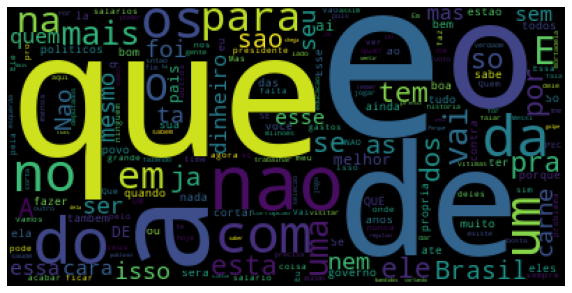

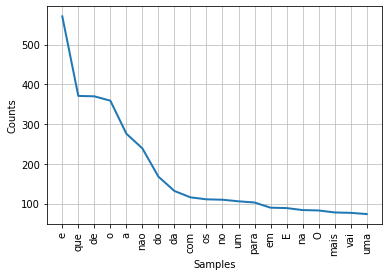

In [ ]:
#Palavras com maior frequência no dataframe sem retirada de stopwords
allWords_data_1, freq_data_1 = plotarNuvem(tokenized_data_frame)
plotFrenquencies(freq_data_1)

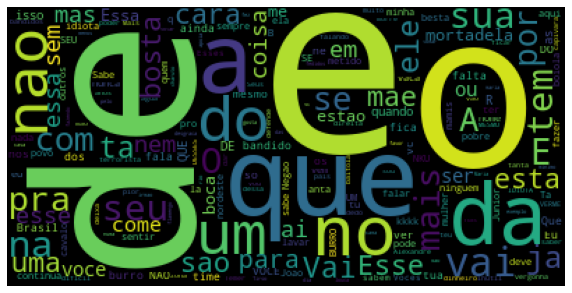

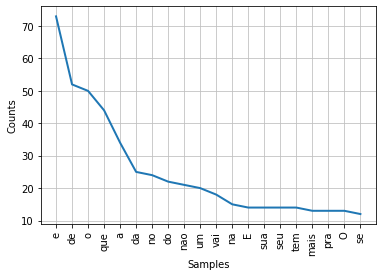

In [ ]:
#Palavras com maior frequência no dataframe HATE

allWords_hate, freq_hate = plotarNuvem(tokenized_hate_data_frame)
plotFrenquencies(freq_hate)

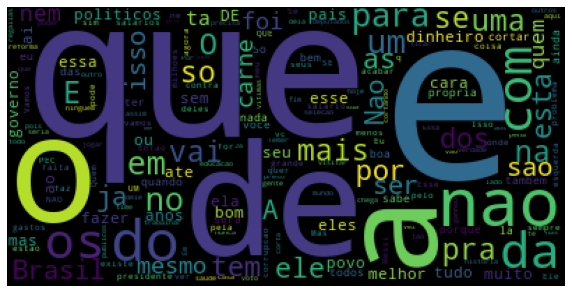

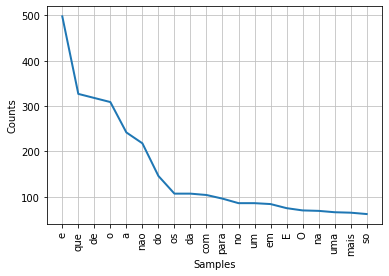

In [ ]:
#Palavras com maior frequência no dataframe NO HATE

allWords_nohate, freq_nohate = plotarNuvem(tokenized_no_hate_data_frame)
plotFrenquencies(freq_nohate)

Nota-se que as palavras de maior frequência que aparecem nos três *dataframes* são muito parecidas e são conectivos. Isto é palavras que, geralmente, não acrescentam muita informação na frase. Em seguida, essas palavras serão consideradas *stopwords* e serão retiradas do *dataset*

## Removendo pontuação, *stopwords*, ...

**Conceitos sobre pré-processamento de dados:**

*removing pontuaction* 
- a remoção de pontuação pode ser feita retirando a pontuação por completo ou substituindo-a por outro caractere como o espaço. Ambas as formas possuem desvantagens:

       it's -> it s (o 's' torna-se uma palavra do vocabulário da base: pode ser preciso removê-la posteriormente como uma *stopword*)

      Ireland-related -> Irelandrelated (x)

*stopwords* 
- é uma lista de palavras que vão ser desconsideradas. Geralmente, são palavras que possuem um significado linguístico/gramatical mas não agregam muito conteúdo para o significado da frase. Além disso podem ser agregadas à lista palavras que no contexto do *dataframe* estudado possuem uma frequência muito alta de forma que, em problemas de classificação, elas não ajudem a diferenciar entre as classes. 
- retirar palavras menores do que um determinado tamanho

*altering the text* 
- palavras iguais mas que estão com letra maiuscula/minuscula serão consideradas palavras diferentes no vocabulário se não forem corrigidas. Essa correção deve ser feita com cuidado pois podem existir situações em que se queira ter essa distinção.
- pode-se tentar corrigir *typos*

*stemming* 
- palavras ligeiramente diferentes mas que possuem o mesmo significado podem ser substituidas pela mesma palavra
      andamos, andar, andei, andarei -> andar
- *Porter Algorithm*

É importante ressaltar que a ordem com que esses passos são realizados muitas vezes altera o resultado final do *dataframe* e, portanto, a estratégia de processamento deve ser previamente definida ou testada de diferentes formas.

In [ ]:
#Retirando pontuações e stopwords pré-definidas para a língua portuguesa pelo nltk

stopwords_1 = set(stopwords.words('portuguese')+list(punctuation))
print(stopwords_1)

{'num', 'numa', 'ou', '[', 'houvéramos', 'tenham', 'houvermos', 'minha', 'forem', 'tiveram', 'mas', 'estamos', 'este', 'teríamos', 'hei', 'hajam', 'aos', 'estejamos', 'aquilo', 'estive', 'terei', 'houvemos', 'hão', '%', 'às', 'ela', 'teu', 'delas', 'sejam', '/', 'nosso', 'teriam', 'fôssemos', '@', 'estava', '_', '^', 'nos', 'e', 'teve', 'houveram', 'fôramos', ']', 'tivesse', 'esses', 'há', '.', 'o', 'tive', 'estávamos', 'houvessem', 'nem', 'das', 'fossem', 'não', 'estejam', 'se', 'por', 'meus', '~', 'isto', 'serão', 'éramos', 'temos', 'esteja', 'sua', 'esta', 'um', 'esse', 'uma', 'aquele', '>', 'suas', 'sem', 'em', 'elas', 'nossa', 'minhas', 'vos', 'somos', 'tinham', 'tenha', '\\', 'tivéssemos', 'sejamos', 'as', 'essas', '?', 'estivemos', 'houveria', 'ao', 'lhe', 'que', 'seríamos', 'como', 'estiverem', 'muito', 'eu', 'até', 'na', '<', 'estivéssemos', 'à', 'no', 'houverei', 'pelos', 'estivéramos', ')', '!', 'dos', 'aquelas', 'os', '-', 'houveremos', 'te', 'formos', 'houvera', 'foram', '

In [ ]:
def removeStopWords(text):
  #text.lower -> transforma todas as letras em minúculas
  #text ainda não foi tokenizado
  filteredWords = [word for word in word_tokenize(text.lower()) if word not in stopwords_1]
  return [word for word in filteredWords if len(word) > 1]

In [ ]:
tokenized_data_frame_1 = data_frame[:]['Data'].apply(removeStopWords)

tokenized_hate_data_frame_1 = hate_data_frame['Data'].apply(removeStopWords)

tokenized_no_hate_data_frame_1 = no_hate_data_frame['Data'].apply(removeStopWords)

**Gráficos**

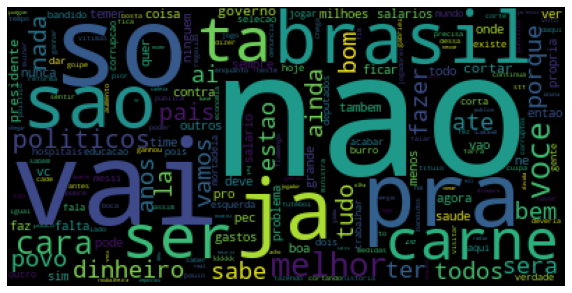

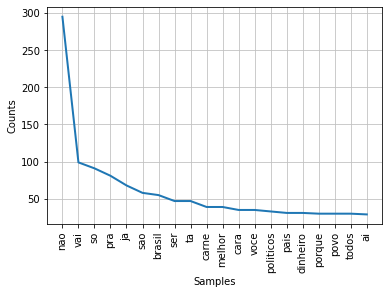

In [ ]:
#Palavras com maior frequência no dataframe retirando stopwords (pontuação e lista pt)
allWords_data_basico, freq_data_basico = plotarNuvem(tokenized_data_frame_1)
plotFrenquencies(freq_data_basico)

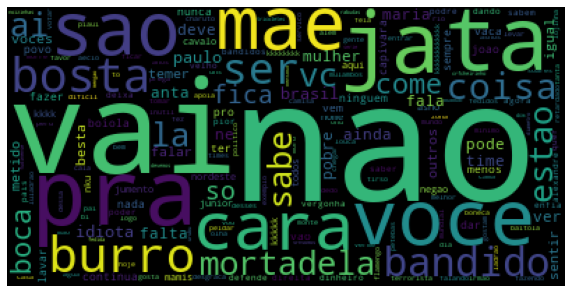

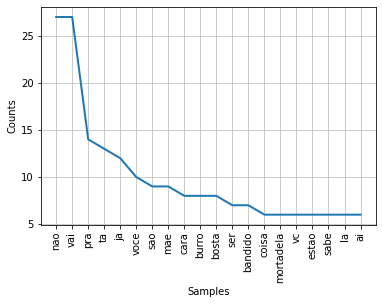

In [ ]:
#Palavras com maior frequência no dataframe hate retirando stopwords (pontuação e lista pt)
allWords_data, freq_data = plotarNuvem(tokenized_hate_data_frame_1)
plotFrenquencies(freq_data)

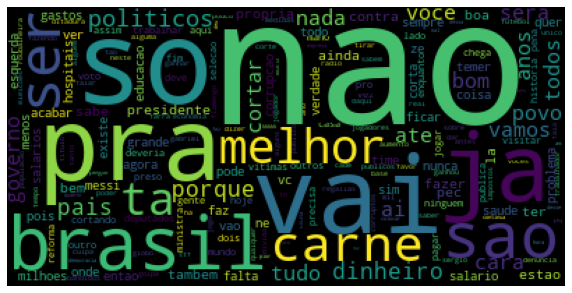

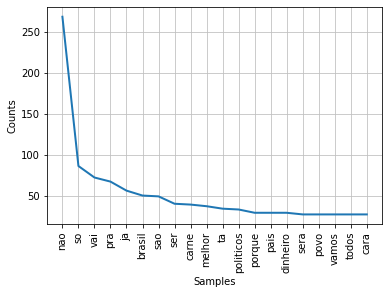

In [ ]:
#Palavras com maior frequência no dataframe no hate retirando stopwords (pontuação e lista pt)
allWords_data, freq_data = plotarNuvem(tokenized_no_hate_data_frame_1)
plotFrenquencies(freq_data)

Percebe-se que as palavras de maior frequência foram retiradas, mas que as palavras de maior frequência ainda são as mesmas para os *dataframes* de ódio e não ódio. 

In [ ]:
#Palavras que aparecem com alta frequência em ambos os casos

unwantedChars = [
    '\'', 
    '\"',
    '/p',
    'ª',
    'º',
    '.',
    '!',
    '?',
    ',',
    ';',
    ':',
    '-',
    '\'',
    '!!'
    ]

    

palavras = {
    'nao',
    'vai',
    'pra',
    'para',
    'ja',
    'sao',
    'ser',
    'la',
    'ai',
    'ta',
    'so',
    'ne',
    'la',
    'brasil',
    'carne'
}

In [ ]:
#Como visualizar todos os dados da tabela
df = pd.DataFrame(data_frame) 
df

,Label,Data
0,yes,Votaram no PEZAO Agora tomem no CZAO
1,no,cuidado com a poupanca pessoal Lembram o que a...
2,no,Sabe o que eu acho engracado os nossos governa...
3,no,Podiam retirar dos lucros dos bancos
4,no,CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUUU...
...,...,...
1028,no,Cruz so tem agilidade mesmo poder de nocaute z...
1029,no,Meus caros amigos enigmaticosNao deveriam comp...
1030,yes,Ele chamava pra atras da escola e sentava nos ...
1031,no,Jhalim Rabei ate fiquei assustado comecei a le...


In [ ]:
stopwords_2 = set(stopwords.words('portuguese')+list(punctuation)+ list(unwantedChars)+ list(palavras))


In [ ]:
def removeStopWords2(text):
  #text.lower -> transforma todas as letras em minúculas
  #text ainda não foi tokenizado
  filteredWords = [word for word in word_tokenize(text.lower()) if word not in stopwords_2]
  return [word for word in filteredWords if len(word) > 1]

In [ ]:
tokenized_data_frame_2 = data_frame[:]['Data'].apply(removeStopWords2)

tokenized_hate_data_frame_2 = hate_data_frame['Data'].apply(removeStopWords2)

tokenized_no_hate_data_frame_2 = no_hate_data_frame['Data'].apply(removeStopWords2)

In [ ]:
df = pd.DataFrame(tokenized_data_frame_2)
df

,Data
0,"[votaram, pezao, agora, tomem, czao]"
1,"[cuidado, poupanca, pessoal, lembram, acontece..."
2,"[sabe, acho, engracado, governantes, pensam, c..."
3,"[podiam, retirar, lucros, bancos]"
4,"[cade, galvao, narrar, agora, faliiiiuuuuuuu, ..."
...,...
1028,"[cruz, agilidade, poder, nocaute, zero, cody, ..."
1029,"[caros, amigos, enigmaticosnao, deveriam, comp..."
1030,"[chamava, atras, escola, sentava, garotos, kkkk]"
1031,"[jhalim, rabei, ate, fiquei, assustado, comece..."


**Gráficos**

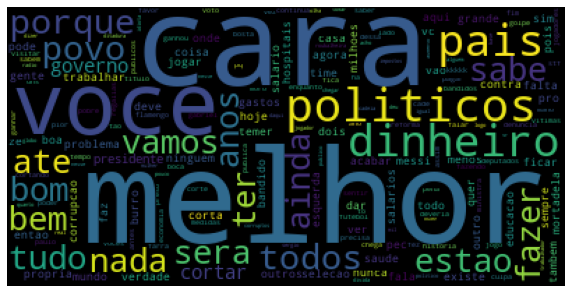

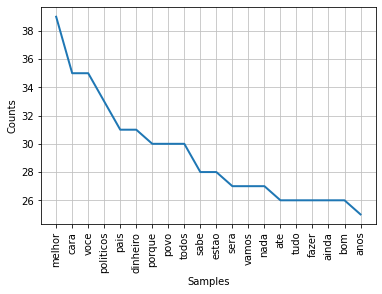

In [ ]:
#Palavras com maior frequência no dataframe retirando stopwords (pontuação + lista pt + lista pessoal de palavras)
allWords_data_final, frequencies_final = plotarNuvem(tokenized_data_frame_2)
plotFrenquencies(frequencies_final)

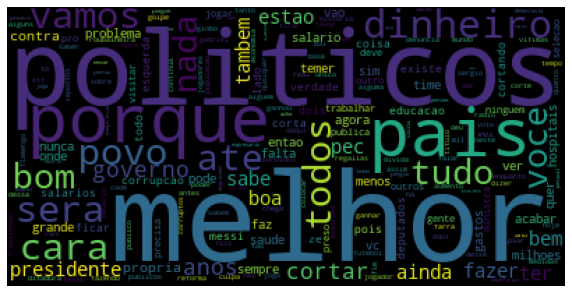

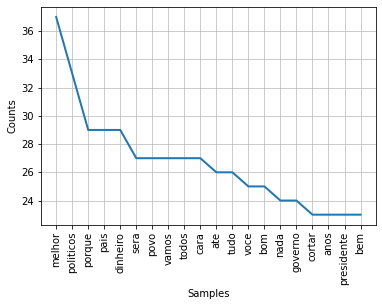

In [ ]:
#Palavras com maior frequência no dataframe no hate retirando stopwords (pontuação + lista pt + lista pessoal de palavras)
allWords_data_nohate, freq_data = plotarNuvem(tokenized_no_hate_data_frame_2)
plotFrenquencies(freq_data)

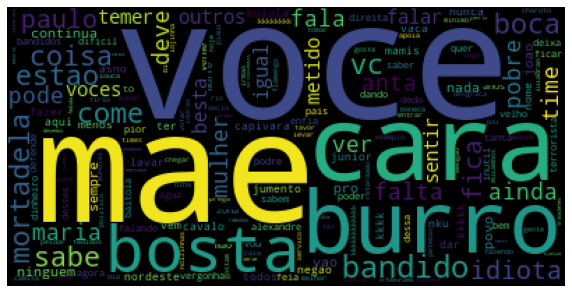

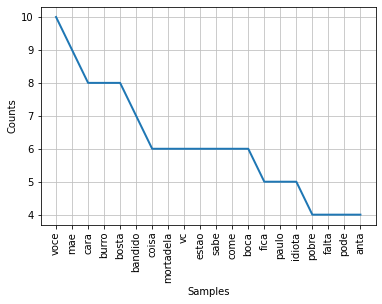

In [ ]:
#Palavras com maior frequência no dataframe hate retirando stopwords (pontuação + lista pt + lista pessoal de palavras)
allWords_data_hate, freq_data = plotarNuvem(tokenized_hate_data_frame_2)
plotFrenquencies(freq_data)

# Extraindo *Features*

**Bag of Words**

*Vocabulário* - lista de palavras que aparecem nos textos 

*Vetoriza-se os textos* - cada texto passa a ser descrito como um vetor que diz se uma determinada palavra *x* está inclusa ou não naquele texto
  - *CountVectorizer*: conta-se a quantidade de vezes que um determinado *token* aparece no texto. Contrói uma matriz esparsa com todos os x *tokens*.
  - TF-IDF *Vectorizer* (*term frequency-inverse document frequency*): é uma medida estatística que dá um peso para cada *token*, medindo a importância daquela palavra no documento. A importância aumenta porporcionalmente ao número de vezes que uma determinada palavra aparece no texto e é diminuida pela frequência dessa palavra no vocabulário. 

        TF(t) = número de vezes que t aparece no documento/número de palavras no documento
        IDF(t) = ln(número de documentos/número de documentos que contém t)
        TF-IDF(t) = TF*IDF

**Desvantagens**

  - O modelo *Bag of Words* não leva em consideração a ordem das palavras na frase. 

  - É preciso ser bastante cuidadoso ao se fazer o vocabulário, pois ele representará todo o mundo de palavras. 

  - Se existem muitas palavras no vocabulário, os vetores podem se tornar muito esparsos. 

In [ ]:
#Construindo o vocabulário para o BoW

def extractNumericalBoW(frase, total_features_map):
  words = set(frase)
  word_features = {}

  for w in total_features_map:
    count = 0

    for word in words:
      if word == w:
        count = count+1

    word_features[w] = count

  return word_features


In [ ]:
#lista com todas as palavras distintas 
total_features_map = list(frequencies_final.keys())[:]

#lista das classificações
Y_data = [label for label in data_frame[:]['Label']]
X_data = []

for i in range(len(allWords_data_final)):
   X_data.append((extractNumericalBoW(allWords_data_final[i], total_features_map), Y_data[i]))

# X_data é do tipo [({'votaram': 1, 'a' : 0, ....}, 'yes'), ({'votaram':0, 'a':1, ...}, 'no')]

In [ ]:
allWords_data_final[0]

['votaram', 'pezao', 'agora', 'tomem', 'czao']

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import joblib

joblib.dump(total_features_map, "features_ddo_estudo.pkl")

['features_ddo_estudo.pkl']

# Classificação

## Busca dos melhores parâmetros

*Support Vector Machine* (SVM)


*  O aprendizado consiste na definição de hiperplanos que separam as classes do problema
*   Caso o problema seja não linear é preciso transformá-lo em um problema linear para que se possa utilizar um hiperplano para separar as classes. Para fazer isso usa-se os chamados de *kernel tricks* que adicionam uma nova dimensão ao problema, criando um novo atributo: *slack variable*.

*Random Forest*

*Naive Bayes*

In [ ]:
# kfold -> nº de partes que o dataset vai ser separado


def TrainClassifierWithScore (kfold, X_data_np, Y_data_np, classifier_type):

  scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

  cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

  # C: default = 1, the strength of the regularization is inversely proportional to C
  # gamma: {'scale', 'auto'} ou float
  # 'auto' = 1/n_features
  # 'scale' = 1/(n_features*X.var())
  # class_weight: sets C -> class_weight[i]*C
  # 'balanced' = n_samples/(n_classes*np.bincount(y))
  #np.bincount -> Count number of occurrences of each value in array of non-negative ints

  if classifier_type == 'svm_poly':
    classifier = SVC(kernel='poly', C=0.45, probability=True, gamma='auto', class_weight='balanced')
      
  elif classifier_type == 'svm_rbf':
    classifier = SVC(kernel='rbf', C=0.45, probability=True, gamma='auto', class_weight='balanced')
      
  # Melhor configuração segundo o GridSearch -> buscando a melhor f1 score
  elif classifier_type == 'svm_linear_Grid':
    classifier = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')

  elif classifier_type == 'svm_linear':
    classifier = SVC(kernel='linear', C=0.45, probability=True, gamma='auto', class_weight='balanced')

  elif classifier_type == 'naive_gaussiano':
    classifier = GaussianNB()

  elif classifier_type == 'naive_bernoulli':
    classifier = BernoulliNB(binarize = None)

  # Melhores parâmetros segundo o GridSearch
  elif classifier_type == 'random_forest_Grid':
    classifier = RandomForestClassifier(n_estimators = 200, criterion='gini', max_depth = 110, min_samples_leaf=1, min_samples_split=2 )

  #Parâmetros usados pelas meninas
  elif classifier_type == 'random_forest':
    classifier = RandomForestClassifier(n_estimators=100)

  results = cross_validate(estimator = classifier, X = X_data_np, y = Y_data_np, cv = cv, scoring = scoring, return_train_score = True)

  return results

def DictToArray(X_data):

  X_data_array = []
  Y_data_array = []

  for X in X_data:
    feature = []
    for feat in X[0].values():
      feature.append(feat)

    X_data_array.append(feature)
    Y_data_array.append(1 if X[1] == 'yes' else 0)

  X_data_np = np.array(X_data_array)
  Y_data_np = np.array(Y_data_array, dtype = int)

  return X_data_np, Y_data_array



In [ ]:
X_data_np, Y_data_np = DictToArray(X_data)

Busca dos melhores hyperparâmetros através do GridSearch

In [ ]:
kfold = 5

parametros = {
    'kernel': ['linear','poly','rbf'],
    'gamma': ['auto', 'scale'],
    'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
    'class_weight' : ['balanced']
}

scoring = ['accuracy', 'average_precision', 'f1', 'precision', 'recall', 'roc_auc']

cv = KFold(n_splits = kfold, shuffle = True, random_state = 42)

grid = GridSearchCV(
    estimator = SVC(),
    param_grid = parametros,
    cv = cv,
    scoring = scoring,
    refit =  'f1',
    verbose = 3
)

grid.fit(X_data_np, Y_data_np)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.787, average_precision=0.544, f1=0.463, precision=0.576, recall=0.388, roc_auc=0.747, total=   5.3s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.836, average_precision=0.539, f1=0.564, precision=0.550, recall=0.579, roc_auc=0.780, total=   5.3s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.6s remaining:    0.0s


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.773, average_precision=0.399, f1=0.390, precision=0.349, recall=0.441, roc_auc=0.750, total=   5.3s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.782, average_precision=0.467, f1=0.430, precision=0.415, recall=0.447, roc_auc=0.776, total=   5.3s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=linear .........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=linear, accuracy=0.801, average_precision=0.555, f1=0.481, precision=0.528, recall=0.442, roc_auc=0.806, total=   5.3s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.237, average_precision=0.554, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.781, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.562, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.756, total=   6.0s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.457, f1=0.318, precision=0.189, recall=1.000, roc_auc=0.787, total=   6.0s
[CV] C=0.1, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   6.0s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.1, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.798, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   5.9s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.609, average_precision=0.400, f1=0.441, precision=0.333, recall=0.653, roc_auc=0.666, total=   5.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.585, average_precision=0.330, f1=0.377, precision=0.260, recall=0.684, roc_auc=0.670, total=   5.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.594, average_precision=0.336, f1=0.354, precision=0.240, recall=0.676, roc_auc=0.670, total=   5.8s
[CV] C=0.1, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.1, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.554, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.400, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   6.0s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.457, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   6.0s
[CV] C=0.3, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.3, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   6.0s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.3, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.799, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   5.9s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.662, average_precision=0.426, f1=0.453, precision=0.367, recall=0.592, roc_auc=0.688, total=   5.5s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.643, average_precision=0.380, f1=0.403, precision=0.291, recall=0.658, roc_auc=0.694, total=   5.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.657, average_precision=0.370, f1=0.360, precision=0.260, recall=0.588, roc_auc=0.688, total=   5.6s
[CV] C=0.3, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.3, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.400, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=poly ..........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weig

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.457, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=auto, kernel=rbf ...........
[CV]  C=0.45, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   6.0s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=linear .......
[CV]  C=0.45, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.525, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.779, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=poly .........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=poly .........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.801, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=poly .........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   5.9s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.700, average_precision=0.437, f1=0.475, precision=0.406, recall=0.571, roc_auc=0.701, total=   5.4s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.715, average_precision=0.426, f1=0.438, precision=0.343, recall=0.605, roc_auc=0.713, total=   5.5s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.715, average_precision=0.408, f1=0.392, precision=0.302, recall=0.559, roc_auc=0.703, total=   5.6s
[CV] C=0.45, class_weight=balanced, gamma=scale, kernel=rbf ..........
[CV]  C=0.45, class_wei

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.400, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   6.0s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=ba

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.457, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   6.0s
[CV] C=0.5, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.5, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   6.0s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.5, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.493, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.749, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.519, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.780, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.789, total=   5.9s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.710, average_precision=0.443, f1=0.455, precision=0.410, recall=0.510, roc_auc=0.703, total=   5.4s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.729, average_precision=0.433, f1=0.451, precision=0.359, recall=0.605, roc_auc=0.718, total=   5.4s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.734, average_precision=0.412, f1=0.409, precision=0.322, recall=0.559, roc_auc=0.707, total=   5.5s
[CV] C=0.5, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.5, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.554, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.400, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   6.0s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.457, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.6, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.6, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.526, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.398, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.778, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   5.9s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.758, average_precision=0.459, f1=0.500, precision=0.490, recall=0.510, roc_auc=0.711, total=   5.4s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.773, average_precision=0.447, f1=0.472, precision=0.412, recall=0.553, roc_auc=0.726, total=   5.4s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.754, average_precision=0.434, f1=0.414, precision=0.340, recall=0.529, roc_auc=0.714, total=   5.5s
[CV] C=0.6, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.6, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.763, average_precision=0.554, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.781, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.791, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.791, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.763, average_precision=0.562, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   6.0s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   6.0s
[CV] C=0.7, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.791, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.792, total=   6.0s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.802, average_precision=0.544, f1=0.388, precision=0.722, recall=0.265, roc_auc=0.751, total=   5.1s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.850, average_precision=0.586, f1=0.475, precision=0.667, recall=0.368, roc_auc=0.774, total=   5.2s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=linear, accuracy=0.831, average_precision=0.426, f1=0.364, precision=0.476, recall=0.294, roc_auc=0.718, total=   5.2s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.7, class_w

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.532, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.782, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.777, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.475, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   5.9s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.778, average_precision=0.469, f1=0.500, precision=0.535, recall=0.469, roc_auc=0.716, total=   5.4s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.787, average_precision=0.474, f1=0.463, precision=0.432, recall=0.500, roc_auc=0.733, total=   5.4s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.778, average_precision=0.451, f1=0.410, precision=0.364, recall=0.471, roc_auc=0.717, total=   5.5s
[CV] C=0.7, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.7, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.400, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.787, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=poly ...........
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.237, average_precision=0.562, f1=0.383, precision=0.237, recall=1.000, roc_auc=0.756, total=   6.0s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.457, f1=0.318, precision=0.189, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=auto, kernel=rbf ............
[CV]  C=0.8, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   6.0s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=linear ........
[CV]  C=0.8, class_weight=balanc

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.746, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.535, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.783, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.475, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.802, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=poly ..........


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.467, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.794, total=   5.9s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.802, average_precision=0.486, f1=0.518, precision=0.611, recall=0.449, roc_auc=0.721, total=   5.3s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.792, average_precision=0.492, f1=0.427, precision=0.432, recall=0.421, roc_auc=0.739, total=   5.4s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.802, average_precision=0.460, f1=0.423, precision=0.405, recall=0.441, roc_auc=0.720, total=   5.6s
[CV] C=0.8, class_weight=balanced, gamma=scale, kernel=rbf ...........
[CV]  C=0.8, class_weight=b

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.816, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.795, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.164, average_precision=0.448, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.805, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.184, average_precision=0.400, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=poly .............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=poly, accuracy=0.209, average_precision=0.450, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.791, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, ga

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.816, average_precision=0.539, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   6.0s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.164, average_precision=0.419, f1=0.282, precision=0.164, recall=1.000, roc_auc=0.783, total=   6.0s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.184, average_precision=0.457, f1=0.311, precision=0.184, recall=1.000, roc_auc=0.787, total=   6.0s
[CV] C=1, class_weight=balanced, gamma=auto, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=auto, kernel=rbf, accuracy=0.209, average_precision=0.455, f1=0.345, precision=0.209, recall=1.000, roc_auc=0.792, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=linear ..........
[CV]  C=1, class_weight=balanced, gamma=

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.763, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.745, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.544, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.788, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.836, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.772, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.816, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.804, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=poly ............


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  C=1, class_weight=balanced, gamma=scale, kernel=poly, accuracy=0.791, average_precision=0.468, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.790, total=   5.9s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.783, average_precision=0.499, f1=0.400, precision=0.577, recall=0.306, roc_auc=0.729, total=   5.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.831, average_precision=0.522, f1=0.426, precision=0.565, recall=0.342, roc_auc=0.752, total=   5.5s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=scale, kernel=rbf, accuracy=0.836, average_precision=0.453, f1=0.452, precision=0.500, recall=0.412, roc_auc=0.721, total=   5.6s
[CV] C=1, class_weight=balanced, gamma=scale, kernel=rbf .............
[CV]  C=1, class_weight=balanced, g

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 22.5min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.3, 0.45, 0.5, 0.6, 0.7, 0.8, 1],
                         'class_weight': ['balanced'],
                         'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf']},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=['accuracy', 'average_precision', 'f1', 'precision',
                      'recall', 'roc_auc'],
             verbose=3)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

0.4657039985845173
{'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}


In [ ]:
results = grid.cv_results_
results = pd.DataFrame(results)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_gamma,param_kernel,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_average_precision,split1_test_average_precision,split2_test_average_precision,split3_test_average_precision,split4_test_average_precision,mean_test_average_precision,std_test_average_precision,rank_test_average_precision,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,3.539334,0.021902,1.742924,0.007429,0.1,balanced,auto,linear,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.787440,0.835749,0.772947,0.781553,0.800971,0.795732,0.021990,22,0.543573,0.538669,0.398859,0.466938,0.555121,0.500632,0.059586,15,0.463415,0.564103,0.389610,0.430380,0.481013,0.465704,0.058241,1,0.575758,0.550000,0.348837,0.414634,0.527778,0.483401,0.086915,16,0.387755,0.578947,0.441176,0.447368,0.441860,0.459422,0.063575,22,0.746642,0.779742,0.750000,0.776159,0.806392,0.771787,0.021849,25
1,3.947837,0.012526,1.961802,0.003427,0.1,balanced,auto,poly,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.236715,0.816425,0.164251,0.815534,0.208738,0.448333,0.301071,35,0.554282,0.508091,0.448112,0.400301,0.450117,0.472181,0.053410,29,0.382812,0.000000,0.282158,0.000000,0.345382,0.202070,0.168098,34,0.236715,0.000000,0.164251,0.000000,0.208738,0.121941,0.102212,35,1.000000,0.000000,1.000000,0.000000,1.000000,0.600000,0.489898,11,0.781323,0.795157,0.804998,0.786811,0.790840,0.791826,0.008013,1
2,3.978929,0.013194,1.992324,0.004772,0.1,balanced,auto,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.236715,0.816425,0.164251,0.208738,0.208738,0.326973,0.245824,41,0.562371,0.539331,0.419088,0.457383,0.455217,0.486678,0.054623,18,0.382812,0.000000,0.282158,0.317992,0.345382,0.265669,0.136869,25,0.236715,0.000000,0.164251,0.189055,0.208738,0.159752,0.083334,26,1.000000,0.000000,1.000000,1.000000,1.000000,0.800000,0.400000,1,0.755877,0.789941,0.783067,0.787281,0.792053,0.781644,0.013228,10
3,3.537830,0.019298,1.754268,0.008996,0.1,balanced,scale,linear,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.787440,0.835749,0.772947,0.781553,0.800971,0.795732,0.021990,22,0.543573,0.538669,0.398859,0.466938,0.555121,0.500632,0.059586,15,0.463415,0.564103,0.389610,0.430380,0.481013,0.465704,0.058241,1,0.575758,0.550000,0.348837,0.414634,0.527778,0.483401,0.086915,16,0.387755,0.578947,0.441176,0.447368,0.441860,0.459422,0.063575,22,0.746642,0.779742,0.750000,0.776159,0.806392,0.771787,0.021849,25
4,3.955913,0.007522,1.960417,0.005926,0.1,balanced,scale,poly,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.241546,0.816425,0.835749,0.815534,0.791262,0.700103,0.229713,29,0.538673,0.503345,0.406283,0.447097,0.418639,0.462807,0.050580,41,0.384314,0.000000,0.000000,0.000000,0.000000,0.076863,0.153725,40,0.237864,0.000000,0.000000,0.000000,0.000000,0.047573,0.095146,41,1.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.400000,40,0.778804,0.798194,0.787402,0.798716,0.776644,0.787952,0.009302,9
5,3.897918,0.012861,1.927909,0.005417,0.1,balanced,scale,rbf,"{'C': 0.1, 'class_weight': 'balanced', 'gamma'...",0.608696,0.584541,0.594203,0.548544,0.611650,0.589527,0.022730,33,0.399919,0.330389,0.335540,0.287534,0.386234,0.347923,0.040691,48,0.441379,0.376812,0.353846,0.358621,0.420290,0.390190,0.034707,24,0.333333,0.260000,0.239583,0.242991,0.305263,0.27623

In [ ]:
parametros_forest = {
    'n_estimators': [100, 200, 300],
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [80, 90, 100, 110],
    'min_samples_split'  : [2, 5, 8, 10],
    'min_samples_leaf' : [1, 3, 5]
}

grid_forest = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = parametros_forest,
    scoring = scoring,
    refit = 'f1',
    cv = 5,
    verbose = 3
)

grid_forest.fit(X_data_np, Y_data_np)



Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.448, f1=0.174, precision=0.800, recall=0.098, roc_auc=0.642, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.812, average_precision=0.456, f1=0.204, precision=0.625, recall=0.122, roc_auc=0.716, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.836, average_precision=0.418, f1=0.292, precision=0.875, recall=0.175, roc_auc=0.622, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.835, average_precision=0.445, f1=0.320, precision=0.800, recall=0.200, roc_auc=0.642, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.374, f1=0.136, precision=0.750, recall=0.075, roc_auc=0.667, total=   1.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=200, accur

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.458, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.731, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   1.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.405, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.680, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.365, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.652, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.521, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.766, total=   1.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.343, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.737, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.751, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.334, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.811, average_precision=0.349, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.646, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.530, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.766, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.419, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.528, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.333, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.632, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.758, total=   1.1s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.407, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.671, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.351, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.620, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.525, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.812, average_precision=0.457, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.719, total=   0.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.443, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.685, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.505, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   1.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.2s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.489, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.753, total=   1.7s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   1.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.347, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   1.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.241, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.546, total=   0.4s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.616, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.270, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.567, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.376, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.323, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.627, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.278, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.579, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.313, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.255, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.550, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.585, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.331, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.276, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.593, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.608, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.289, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.583, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.746, total=   0.5s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.615, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.280, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.571, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.338, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.544, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.559, total=   0.3s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.694, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.385, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.591, total=   0.6s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.8s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   0.9s
[CV] criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.580, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.464, f1=0.213, precision=0.833, recall=0.122, roc_auc=0.687, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.797, average_precision=0.437, f1=0.160, precision=0.444, recall=0.098, roc_auc=0.677, total=   1.4s
[CV] criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accu

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.402, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.336, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.614, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.334, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   1.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.464, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.811, average_precision=0.455, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.704, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.612, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.811, average_precision=0.423, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.692, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.811, average_precision=0.337, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.628, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   1.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.750, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.811, average_precision=0.348, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.638, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.327, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.349, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.640, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.352, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.661, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.491, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.748, total=   1.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   1.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.518, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.425, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.701, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.334, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.489, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.751, total=   1.1s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.2s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.448, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.716, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.361, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.648, total=   1.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   1.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.465, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   1.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   1.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.592, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.465, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.733, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.266, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.597, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.290, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.568, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   0.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.323, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.374, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.366, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.251, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.563, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.401, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.613, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.588, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.312, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.351, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.664, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.262, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.592, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.480, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   0.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.330, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.291, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.593, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.271, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.591, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.610, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.469, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   0.5s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.7s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.600, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.255, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.564, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.457, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.416, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.303, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.607, total=   0.3s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.477, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.586, total=   0.6s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.748, total=   0.8s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.615, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.9s
[CV] criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.590, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.453, f1=0.213, precision=0.833, recall=0.122, roc_auc=0.667, total=   1.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.461, f1=0.174, precision=0.800, recall=0.098, roc_auc=0.699, total=   1.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.508, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.748, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.615, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.812, average_precision=0.428, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.714, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.507, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.760, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.351, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.498, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.467, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.811, average_precision=0.432, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.688, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   1.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   2.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   1.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.778, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.610, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.443, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.701, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.364, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.639, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.477, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.347, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.447, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.422, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.686, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.496, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   1.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   1.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.761, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.683, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.741, total=   1.1s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.317, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   1.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   1.2s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   1.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   1.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.477, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.736, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.313, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.477, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.752, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.320, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.252, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.556, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.453, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.702, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.604, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.349, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.599, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.476, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.295, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.349, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.288, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.594, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.294, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.599, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.675, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   0.7s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   1.0s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.252, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.554, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.731, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.4s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.250, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.543, total=   0.3s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   0.5s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.311, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.610, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.255, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.548, total=   0.6s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.502, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.751, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.305, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.374, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.8s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.9s
[CV] criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.599, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.399, f1=0.213, precision=0.833, recall=0.122, roc_auc=0.636, total=   1.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.441, f1=0.174, precision=0.800, recall=0.098, roc_auc=0.699, total=   1.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=10

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.468, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.366, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.758, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.812, average_precision=0.444, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.718, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.343, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.639, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   1.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.811, average_precision=0.443, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.702, total=   1.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.740, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.323, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.811, average_precision=0.363, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.645, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.483, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.746, total=   1.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   1.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.499, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.610, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.435, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.710, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.357, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.647, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.497, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.378, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.644, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   1.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.448, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.691, total=   1.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.811, average_precision=0.372, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.659, total=   1.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.766, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.360, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.462, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.422, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.337, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.642, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.513, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.749, total=   1.1s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.336, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.712, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.420, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.689, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.372, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   1.2s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.761, total=   1.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.338, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=gini, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.811, average_precision=0.365, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.657, total=   1.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.274, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.270, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.610, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.238, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.554, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.489, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.326, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.664, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.656, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.289, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.611, total=   0.7s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.315, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.562, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.613, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.282, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.643, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.259, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.536, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.679, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.620, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.311, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.595, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.364, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.669, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.302, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.599, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.753, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.301, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.609, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.274, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.451, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.730, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.336, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.330, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.292, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.573, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.473, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.669, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.374, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   1.0s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.580, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.296, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.379, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.330, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.246, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.548, total=   0.3s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.5s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.372, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.343, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.312, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   0.6s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   0.8s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.9s
[CV] criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=gini, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.267, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.572, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.476, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.688, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.816, average_precision=0.451, f1=0.174, precision=0.800, recall=0.098, roc_auc=0.714, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=1, min_samples_split=2, n_e

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.342, f1=0.048, precision=1.000, recall=0.024, roc_auc=0.626, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.739, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.344, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.645, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.745, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.755, total=   1.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.703, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   1.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.487, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.476, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.740, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.439, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.811, average_precision=0.336, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.626, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.760, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.811, average_precision=0.337, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.618, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.750, total=   1.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.735, total=   1.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.517, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.769, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.373, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.645, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.475, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.423, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.674, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.338, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.628, total=   1.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.763, total=   1.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.811, average_precision=0.355, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.632, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.512, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.763, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.338, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.726, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.442, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.692, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.351, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.634, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.493, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.758, total=   1.1s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.424, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.339, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.625, total=   1.2s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.750, total=   1.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.659, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   1.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   1.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.415, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.659, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.327, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.276, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.598, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.413, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.678, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.268, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.578, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.736, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.572, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.395, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.708, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.603, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.412, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.578, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.730, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.308, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.299, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.590, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.392, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.250, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.560, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.723, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.336, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.334, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.259, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.562, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.403, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.305, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.8s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.351, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.570, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.376, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.711, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.320, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.625, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.312, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.598, total=   0.3s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   0.5s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.304, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.267, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.582, total=   0.7s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.411, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.716, total=   0.9s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.377, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.664, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.369, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   1.0s
[CV] criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=80, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.272, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.582, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.454, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.664, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.812, average_precision=0.449, f1=0.170, precision=0.667, recall=0.098, roc_auc=0.712, total=   1.4s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=1, min_samples_split=2, n

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.522, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.775, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.338, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.432, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.332, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.612, total=   0.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.370, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.744, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.347, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.645, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.529, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   1.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.462, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.507, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.768, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.365, f1=0.048, precision=1.000, recall=0.024, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.469, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.707, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.360, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.489, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.750, total=   1.1s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.811, average_precision=0.340, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.630, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   1.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   1.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.746, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.349, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.410, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.355, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.617, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.743, total=   1.1s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.748, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.510, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.760, total=   1.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.444, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.509, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.621, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.472, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.647, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   1.2s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.434, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.693, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.811, average_precision=0.350, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.637, total=   1.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.760, total=   1.7s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.811, average_precision=0.437, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.713, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=90, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.811, average_precision=0.346, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.634, total=   1.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.740, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.276, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.580, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.389, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.260, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.578, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.468, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.727, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.366, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.379, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.304, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.603, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.720, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.319, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.632, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.461, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.378, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.298, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.343, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.314, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.450, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.366, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.331, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.280, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.560, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.484, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.377, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.248, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.552, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.446, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.324, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.300, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.428, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.369, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.305, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.614, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.287, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.584, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.454, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.648, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.387, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.384, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.653, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.3s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.435, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.5s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.383, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.555, total=   0.6s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.500, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.739, total=   0.8s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.330, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.365, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.364, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.667, total=   0.9s
[CV] criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=90, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.588, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.826, average_precision=0.474, f1=0.217, precision=1.000, recall=0.122, roc_auc=0.656, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.486, f1=0.200, precision=0.556, recall=0.122, roc_auc=0.722, total=   1.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_spli

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.520, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.748, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.631, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.360, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.758, total=   1.1s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.722, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.359, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.638, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.503, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.623, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.426, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.811, average_precision=0.338, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.614, total=   1.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.495, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.501, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.766, total=   1.1s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.812, average_precision=0.356, f1=0.093, precision=1.000, recall=0.049, roc_auc=0.654, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.462, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.811, average_precision=0.450, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.704, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.329, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.513, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.371, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.463, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.462, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.811, average_precision=0.375, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.658, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.491, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.761, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.431, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.677, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.811, average_precision=0.329, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.624, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.523, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.770, total=   1.1s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.638, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.458, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.715, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.811, average_precision=0.358, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.631, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.524, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.760, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.346, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.719, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.811, average_precision=0.362, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.645, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.494, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.759, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.651, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.467, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.396, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.811, average_precision=0.347, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.513, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.764, total=   1.1s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.636, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.741, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.449, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.698, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.2s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.511, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   1.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.7s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.731, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.811, average_precision=0.427, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.686, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.334, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.616, total=   1.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.644, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.394, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.311, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.571, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.417, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.388, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.393, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.681, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.380, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.692, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.281, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.558, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.737, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.350, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.381, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.314, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.305, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.592, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.730, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.296, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.404, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.701, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.286, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.600, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.718, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.425, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.659, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.306, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.595, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.406, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.717, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.328, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.621, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.368, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.670, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.321, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.292, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.574, total=   1.0s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.713, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.661, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.310, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.266, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.602, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.429, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.684, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.250, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.565, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.474, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.731, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.384, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.322, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.294, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.455, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.318, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.4s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.276, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.563, total=   0.3s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.739, total=   0.5s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.336, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.679, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.362, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.665, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.559, total=   0.6s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.714, total=   0.8s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.360, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.695, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.9s
[CV] criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=100, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.267, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.565, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.821, average_precision=0.473, f1=0.178, precision=1.000, recall=0.098, roc_auc=0.678, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.448, f1=0.196, precision=0.500, recall=0.122, roc_auc=0.703, total=   1.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=1, min_samples_spl

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.749, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.333, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.641, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.725, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.442, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=100, accuracy=0.811, average_precision=0.372, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.654, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.516, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.756, total=   1.1s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.733, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.443, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=200, accuracy=0.811, average_precision=0.347, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.641, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.733, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.351, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.633, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.729, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.811, average_precision=0.450, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.714, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.482, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.746, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.649, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.438, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.715, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.421, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.682, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.355, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.486, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.747, total=   1.1s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.373, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.660, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.735, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.423, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.680, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.624, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.504, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.762, total=   1.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.360, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.745, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.699, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=5, n_estimators=300, accuracy=0.811, average_precision=0.332, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.610, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.492, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.765, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.663, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.434, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.478, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.749, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.369, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.657, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.812, average_precision=0.446, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.714, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.430, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.369, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.652, total=   1.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.491, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.758, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.735, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.445, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.705, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.626, total=   1.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.506, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.316, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.634, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.441, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.735, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.427, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.700, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.340, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.629, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.487, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.1s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.357, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.646, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.466, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.738, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.437, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.618, total=   1.2s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.488, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.754, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.342, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.642, total=   1.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.460, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   1.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.420, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.697, total=   1.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300 
[CV]  criterion=entropy, max_depth=110, min_samples_leaf=3, min_samples_split=10, n_estimators=300, accuracy=0.811, average_precision=0.348, f1=0.049, precision=1.000, recall=0.025, roc_auc=0.631, total=   1.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.452, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.734, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.802, average_precision=0.325, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.622, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.807, average_precision=0.378, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.672, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.365, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.710, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=100, accuracy=0.806, average_precision=0.279, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.579, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.433, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.802, average_precision=0.356, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.807, average_precision=0.304, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.662, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.347, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.630, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=200, accuracy=0.806, average_precision=0.253, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.547, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.459, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.802, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.687, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.807, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.666, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.354, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   1.0s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=2, n_estimators=300, accuracy=0.806, average_precision=0.285, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.586, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.481, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.757, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.802, average_precision=0.367, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.696, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.807, average_precision=0.361, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.688, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.344, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.637, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=100, accuracy=0.806, average_precision=0.265, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.588, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.436, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.706, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.802, average_precision=0.363, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.689, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.807, average_precision=0.370, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.673, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.335, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.635, total=   0.7s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=200, accuracy=0.806, average_precision=0.320, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.603, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.456, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.724, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.802, average_precision=0.347, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.655, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.807, average_precision=0.303, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.658, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.639, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=5, n_estimators=300, accuracy=0.806, average_precision=0.283, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.578, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.383, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.709, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.802, average_precision=0.347, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.645, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.807, average_precision=0.397, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.732, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.327, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.4s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=100, accuracy=0.806, average_precision=0.304, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.591, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.399, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.802, average_precision=0.332, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.690, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.807, average_precision=0.379, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.339, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.640, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=200, accuracy=0.806, average_precision=0.294, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.567, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.480, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.739, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.802, average_precision=0.349, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.807, average_precision=0.349, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.685, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.650, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=8, n_estimators=300, accuracy=0.806, average_precision=0.273, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.587, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.470, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.721, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.802, average_precision=0.341, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.674, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.807, average_precision=0.366, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.704, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.352, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.617, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=100, accuracy=0.806, average_precision=0.277, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.602, total=   0.3s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.414, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.737, total=   0.5s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.802, average_precision=0.337, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.686, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.807, average_precision=0.359, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.676, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.353, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.668, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=200, accuracy=0.806, average_precision=0.269, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.570, total=   0.6s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.440, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.728, total=   0.8s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.802, average_precision=0.345, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.654, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.807, average_precision=0.348, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.693, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.358, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.659, total=   0.9s
[CV] criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed: 36.3min finished


[CV]  criterion=entropy, max_depth=110, min_samples_leaf=5, min_samples_split=10, n_estimators=300, accuracy=0.806, average_precision=0.280, f1=0.000, precision=0.000, recall=0.000, roc_auc=0.580, total=   0.9s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              warm_start=False),
             iid='deprecated', n_jobs=None,
  

In [ ]:
print(grid_forest.best_score_)
print(grid_forest.best_params_)

0.24837816361868165
{'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
results_forest = grid_forest.cv_results_


In [ ]:
kfold = 5

#training SVM linear model
score_svm_linear = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_linear')

#training SVM linear model with GridSearch parameters
#score_svm_linear_grid = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_linear_Grid')

#training SVM polinomial model
score_svm_poly = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_poly')

#training Svm rbf model
score_svm_rbf = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_rbf')

#training Naive Bayes Gaussian Classifier
score_naive_gauss = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'naive_gaussiano')

#training Naive Bayes Bernoulli Classifier
score_naive_bernoulli = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'naive_bernoulli')

#training Random Forest model
score_random_forest = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'random_forest' )

#training Random Forest model with GridSearch parameters
score_random_forest_Grid = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'random_forest_Grid' )

#training SVM linear model with GridSearch parameters
score_svm_linear_grid = TrainClassifierWithScore(kfold, X_data_np, Y_data_np, 'svm_linear_Grid')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined a

In [ ]:
def printScoreTable(scores, kfold, classifier_type):
  print("\nClassifier:%s" % classifier_type)
  print("K:\tAcc.:\tPre:\tRec.:\tF1-S.:")
  mean_acc = 0
  mean_pre = 0
  mean_rec = 0
  mean_f1 = 0
  for i in range(kfold):
    mean_acc += (scores['test_accuracy'])[i]
    mean_pre += (scores['test_precision'])[i]
    mean_rec += (scores['test_recall'])[i]
    mean_f1 += (scores['test_f1'])[i]
    print("%i\t%.4f\t%.4f\t%.4f\t%.4f\t" % (i+1, scores['test_accuracy'][i], scores['test_precision'][i], scores['test_recall'][i], scores['test_f1'][i]))
  
  print("Mean\t%.4f\t%.4f\t%.4f\t%.4f\t" % (mean_acc/kfold, mean_pre/kfold, mean_rec/kfold, mean_f1/kfold))

In [ ]:
#Teste Linear com os parâmetros das meninas
printScoreTable(score_svm_linear, kfold, 'svm_linear')

#Teste Linear com os parâmetros do GridSearch para melhor 'f1'
printScoreTable(score_svm_linear_grid, kfold, 'svm_linear_GridSearch')

#Teste RBF 
printScoreTable(score_svm_rbf, kfold, 'svm_rbf')

#Teste Poly 
printScoreTable(score_svm_poly, kfold, 'svm_poly')

#Teste Random Forest
printScoreTable(score_random_forest, kfold, 'random_forest')

#Teste Random Forest
printScoreTable(score_random_forest_Grid, kfold, 'random_forest_GridSearch')

#Naive Bayes Gaussiano
printScoreTable(score_naive_gauss, kfold, 'naive_bayes_gaussiano')

#Naive Bayes Bernoulli
printScoreTable(score_naive_bernoulli, kfold, 'naive_bayes_bernoulli')



Classifier:svm_linear
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.8068	0.7368	0.2857	0.4118	
2	0.8502	0.6522	0.3947	0.4918	
3	0.8357	0.5000	0.3529	0.4138	
4	0.8155	0.5000	0.2895	0.3667	
5	0.8350	0.6800	0.3953	0.5000	
Mean	0.8286	0.6138	0.3436	0.4368	

Classifier:svm_linear_GridSearch
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.7874	0.5758	0.3878	0.4634	
2	0.8357	0.5500	0.5789	0.5641	
3	0.7729	0.3488	0.4412	0.3896	
4	0.7816	0.4146	0.4474	0.4304	
5	0.8010	0.5278	0.4419	0.4810	
Mean	0.7957	0.4834	0.4594	0.4657	

Classifier:svm_rbf
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:svm_poly
K:	Acc.:	Pre:	Rec.:	F1-S.:
1	0.2367	0.2367	1.0000	0.3828	
2	0.8164	0.0000	0.0000	0.0000	
3	0.1643	0.1643	1.0000	0.2822	
4	0.1845	0.1845	1.0000	0.3115	
5	0.2087	0.2087	1.0000	0.3454	
Mean	0.3221	0.1588	0.8000	0.2644	

Classifier:random_forest
K:	Acc.:	Pre

## Fazendo o fit e as matrizes de confusão dos melhores modelos

In [ ]:
#pd.Series ela numera o dado
# h = ['a', 'b', 'c']
# index  = [100, 101, 102]
# pd.Series(h, index=index)
# 100  'a'
# 101  'b'
# 102  'c'
y_data = pd.Series(Y_data_np)


In [ ]:
from sklearn.model_selection import train_test_split
# 0,75 -> treino
x_train, x_test, y_train, y_test = train_test_split(X_data_np, y_data, random_state = 42)

#x_train, y_train 774
#x_test, y_test 259

In [ ]:
classifier_svm = SVC(kernel = 'linear', C = 0.1, probability = True, gamma = 'auto', class_weight = 'balanced')
classifier_svm.fit(x_train,y_train)

classifier_naive = GaussianNB()
classifier_naive.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import joblib

joblib.dump(classifier_svm, "SVM_linear_GridSearch_model.pkl")
joblib.dump(classifier_naive, "Naive_model.plk")

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file1 = drive.CreateFile()
file1.SetContentFile("SVM_linear_GridSearch_model.pkl")
file1.Upload()
file1 = drive.CreateFile()
file1.SetContentFile("Naive_model.plk")
file1.Upload()


In [ ]:
import joblib
svm_linear_model = joblib.load('SVM_linear_GridSearch_model.pkl')
naive_model = joblib.load("Naive_model.plk")

In [ ]:
from sklearn.metrics import confusion_matrix
y_predict_svm_linear = svm_linear_model.predict(x_test)
confusion_matrix(y_test, y_predict_svm_linear)

array([[182,  16],
       [ 38,  23]])

In [ ]:
y_predict_naive = naive_model.predict(x_test)
confusion_matrix(y_test, y_predict_naive)

array([[179,  19],
       [ 30,  31]])

## Mas quais são as amostras erroneamente classificadas?

In [ ]:
index = y_test.keys()
data = y_test.array

SVM Linear

In [ ]:
true_positives_svm = []
true_negatives_svm = []
false_positives_svm = []
false_negatives_svm = []

for i in range (len(data)):
  if data[i] == y_predict_svm_linear[i]:
    if data[i] == 1:
      true_positives_svm.append(data_frame.Data[index[i]])
    else:
      true_negatives_svm.append(data_frame.Data[index[i]])
  if data[i] != y_predict_svm_linear[i]:
    if y_predict_svm_linear[i] == 1:
      false_positives_svm.append(data_frame.Data[index[i]])
    if y_predict_svm_linear[i] == 0:
      false_negatives_svm.append(data_frame.Data[index[i]])

In [ ]:
tp_svm = pd.DataFrame(true_positives_svm)
fp_svm = pd.DataFrame(false_positives_svm)
fn_svm = pd.DataFrame(false_negatives_svm)
tn_svm = pd.DataFrame(true_negatives_svm)

In [ ]:
tp_svm.to_csv('tp_svm.csv')
tn_svm.to_csv('tn_svm.csv')
fn_svm.to_csv('fn_svm.csv')
fp_svm.to_csv('fp_svm.csv')
!cp fn_svm.csv "drive/My Drive/"
!cp fp_svm.csv "drive/My Drive/"
!cp tp_svm.csv "drive/My Drive/"
! cp tn_svm.csv "drive/My Drive/"

Naive

In [ ]:
true_positives_naive = []
true_negatives_naive = []
false_positives_naive = []
false_negatives_naive = []

for i in range (len(data)):
  if data[i] == y_predict_naive[i]:
    if data[i] == 1:
      true_positives_naive.append(data_frame.Data[index[i]])
    else:
      true_negatives_naive.append(data_frame.Data[index[i]])
  if data[i] != y_predict_naive[i]:
    if y_predict_naive[i] == 1:
      false_positives_naive.append(data_frame.Data[index[i]])
    if y_predict_naive[i] == 0:
      false_negatives_naive.append(data_frame.Data[index[i]])

In [ ]:
tp_naive = pd.DataFrame(true_positives_naive)
fp_naive = pd.DataFrame(false_positives_naive)
fn_naive = pd.DataFrame(false_negatives_naive)
tn_naive = pd.DataFrame(true_negatives_naive)

In [ ]:
autp_naive.to_csv('tp_naive.csv')
fn_naive.to_csv('fn_naive.csv')
fp_naive.to_csv('fp_naive.csv')
tn_naive.to_csv('tn_naive.csv')
!cp fn_naive.csv "drive/My Drive/"
!cp fp_naive.csv "drive/My Drive/"
!cp tp_naive.csv "drive/My Drive/"
!cp tn_naive.csv "drive/My Drive"